In [83]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import urllib
import urllib.request as ur
import requests
import json
import re
import collections
from uszipcode import SearchEngine
from lxml import html

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import category_encoders as ce

In [2]:
"""
We want to scrape used car listings in all regions, so scrape zipcodes all over major states by population in descending order
"""

zipcodes = []
state_list = ['CA','FL','GA','IL','MD','NC','NJ','NY','OH','PA','TX','VA']

# Gather zipcodes from each state
search = SearchEngine()
for st in state_list:
    res = search.by_state(state=st, returns = 0)
    for r in res:
        zipcodes.append(r.zipcode)

# Shuffle zipcode list - For randomization
random.shuffle(zipcodes)

In [5]:
# Used car listings scraper
def used_car_scraper(n_pages):
    """
    n_pages: number of search pages to scrape. Each page is the search result of a unique zipcode. 
    """
    # Car info we are interested in
    infos = ['makeName','modelName','modelId','carYear','exteriorColorName','localizedTransmission'
         ,'mileage','price','daysOnMarket','bodyTypeName','localizedFuelType','sellerRegion','msrp','ownerCount','accidentCount']
    listings = ['featuredListings','conquestListings','priorityListings','highlightListings','listings'] 
    
    # Dictionary of each automobile's basic information
    automobiles = collections.defaultdict(dict)
    # Dictionary of each automobile's options indlucded
    options_dict = collections.defaultdict(dict) 
    # Index
    idx = 0
    
    for n in range(1,n_pages+1):
        # Webpage scraped by zipcodes
        url = "https://www.cargurus.com/Cars/inventorylisting/viewDetailsFilterViewInventoryListing.action?zip="+zipcodes[n]+"&distance=50"
        response = requests.get(url).text

        data = re.search(r"(?<=window.__PREFLIGHT__ = ).*", response).group()
        data = data[:-1] # Remove last character ;
        data = json.loads(data)
        
        avail_listings = [k for k,v in data.items() if k in listings]
                
        for col in avail_listings: 
            for d in data[col]:
                for i in infos:
                    try:
                        automobiles[idx][i] = d[i]
                    except:
                        automobiles[idx][i] = "N/A"
                if 'options' in d.keys():
                    for o in d['options']:
                        options_dict[idx][o] = True
                idx += 1
                
        if n % 50 == 0:
            print("Page", n, "done")
        
    return automobiles, options_dict

# Scraper to get MSRP of each car model
def msrp_scraper():
    
    listings = ['featuredListings','conquestListings','priorityListings','highlightListings','listings'] 
    
    msrp_dict = collections.defaultdict(list)
    
    for n in range(100):
        url = "https://www.cargurus.com/Cars/new/searchresults.action?zip="+zipcodes[n]+"&showNegotiable=true&sortDir=ASC&sourceContext=untrackedWithinSite_false_0&distance=100&sortType=PROXIMITY"
        response = requests.get(url).text

        data = re.search(r"(?<=window.__PREFLIGHT__ = ).*", response).group()
        data = data[:-1] # Remove last character ;
        data = json.loads(data)
        
        avail_listings = [k for k,v in data.items() if k in listings]
                
        for col in avail_listings: 
            for d in data[col]:
                try:
                    msrp_dict[d['modelId']].append(d['msrp'])
                except:
                    continue
                
        if n % 50 == 0:
            print("Page", n, "done")
        
    return msrp_dict

In [6]:
# Scrape used car listings from 1000 different zipcodes
automobiles, option_dict = used_car_scraper(1000)
msrp_dict = msrp_scraper()

# Average of MSRP for each model 
msrp_avg = {}
for k,v in msrp_dict.items():
    if len(v) > 0:
        msrp_avg[k] = sum(v)/len(v)

Page 50 done
Page 100 done
Page 150 done
Page 200 done
Page 250 done
Page 300 done
Page 350 done
Page 400 done
Page 450 done
Page 500 done
Page 550 done
Page 600 done
Page 650 done
Page 700 done
Page 750 done
Page 800 done
Page 850 done
Page 900 done
Page 950 done
Page 1000 done
Page 0 done
Page 50 done


In [7]:
def preprocess_df(df):
    # Rename columns
    df.rename(columns={"makeName": "Brand", "modelName": "ModelName", "modelId":"ModelID", "carYear":"Year"
                      , "exteriorColorName":"Color", "localizedTransmission":"Transmission", "localizedFuelType":"FuelType"
                      , "sellerRegion":"SellerState", "msrp":"MSRP", "daysOnMarket":"DaysOnMarket", "price":"Price"
                      , "ownerCount":"OwnerCount", "accidentCount":"AccidentCount"}, inplace=True)

    # Drop duplicate rows - it's possible some listings appear more than once due to the search proximity
    df.drop_duplicates(subset=['ModelID','mileage','Price'], inplace=True)

    # Replace N/A with np.nan
    df.replace('N/A', np.nan, inplace=True)

    # Drop all rows with missing price and mileage 
    df.dropna(axis=0, subset=['Price','mileage'], inplace=True)

    # Only cars produced after 2010
    df = df[df['Year'] > 2010]
    
    # Subtract current year with the make year and add it as a column  
    df.loc[:,'YearOld'] = 2022 - df['Year']
    df.drop(['Year'], axis=1, inplace=True)
    
    # Add ID for each row
    df.reset_index(inplace=True)
    df.drop(['index'], axis=1, inplace=True)
    df.loc[:,'id'] = df.index
    
    return df

# Remap Transmission
def remap_transmission(df):
    # Fill np.nan with N/A first
    df['Transmission'].fillna("N/A", inplace=True)
    
    for trans in ['Automatic', 'Continuously', 'CVT', 'Manual', 'Dual']:
        if trans == 'Continuously':
            idx = df['Transmission'].str.contains(trans)
            df.loc[idx, 'Transmission'] = 'CVT'
        else:
            idx = df['Transmission'].str.contains(trans)
            df.loc[idx, 'Transmission'] = trans

    return df

In [8]:
# Automobile Dictionary into df
df_auto = pd.DataFrame.from_dict(automobiles, orient='index',
                       columns=['makeName','modelName','modelId','carYear','exteriorColorName','localizedTransmission'
                               ,'mileage','price','bodyTypeName','localizedFuelType','sellerRegion','msrp','daysOnMarket'
                               ,'ownerCount','accidentCount'])

# Main Options Columns we are interested in
main_options = ['Alloy Wheels','Backup Camera','Bluetooth','Heated Seats','Navigation System','Leather Seats'
               ,'Blind Spot Monitoring','Sunroof/Moonroof','Remote Start','CarPlay','Android Auto','Parking Sensors'
               ,'Adaptive Cruise Control']

# Options Dictionary into df
df_options = pd.DataFrame.from_dict(option_dict, orient='index'
                                   ,columns=main_options).sort_index()

# Join automobiles and options df
df = df_auto.join(df_options)
df = df.pipe(preprocess_df).pipe(remap_transmission)

# Convert options columns into 1 or 0 (NaN should be 0)
df.loc[:,main_options] = df[main_options].fillna(False)
df.loc[:,main_options] = df[main_options].astype('int')


C:\Users\leeja\anaconda3\envs\py37\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\leeja\anaconda3\envs\py37\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\leeja\anaconda3\envs\py37\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

We have a dataset of ~25,000 automobiles listed on the market. 

In [9]:
display(df.info())
display(df.nunique())
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25110 entries, 0 to 25109
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Brand                    25110 non-null  object 
 1   ModelName                25110 non-null  object 
 2   ModelID                  25110 non-null  object 
 3   Color                    25110 non-null  object 
 4   Transmission             25110 non-null  object 
 5   mileage                  25110 non-null  int64  
 6   Price                    25110 non-null  float64
 7   bodyTypeName             25079 non-null  object 
 8   FuelType                 24757 non-null  object 
 9   SellerState              25110 non-null  object 
 10  MSRP                     8306 non-null   float64
 11  DaysOnMarket             25110 non-null  int64  
 12  OwnerCount               24689 non-null  float64
 13  AccidentCount            25067 non-null  float64
 14  Alloy Wheels          

None

Brand                         45
ModelName                    526
ModelID                      526
Color                         14
Transmission                   5
mileage                    22217
Price                      10847
bodyTypeName                   9
FuelType                       8
SellerState                   34
MSRP                        4911
DaysOnMarket                 469
OwnerCount                     8
AccidentCount                  6
Alloy Wheels                   2
Backup Camera                  2
Bluetooth                      2
Heated Seats                   2
Navigation System              2
Leather Seats                  2
Blind Spot Monitoring          2
Sunroof/Moonroof               2
Remote Start                   2
CarPlay                        2
Android Auto                   2
Parking Sensors                2
Adaptive Cruise Control        2
YearOld                       12
id                         25110
dtype: int64

,Brand,ModelName,ModelID,Color,Transmission,mileage,Price,bodyTypeName,FuelType,SellerState,...,Leather Seats,Blind Spot Monitoring,Sunroof/Moonroof,Remote Start,CarPlay,Android Auto,Parking Sensors,Adaptive Cruise Control,YearOld,id
0,Chevrolet,Equinox,d616,UNKNOWN,Automatic,34586,27995.0,SUV / Crossover,Gasoline,PA,...,0,1,0,1,1,1,1,0,4,0
1,Buick,Enclave,d1029,BLACK,Automatic,62538,30989.0,SUV / Crossover,Gasoline,OH,...,1,1,0,1,1,1,1,0,4,1
2,Subaru,Forester,d374,GREEN,Automatic,131787,10500.0,SUV / Crossover,Gasoline,PA,...,1,0,1,0,0,0,0,0,11,2
3,Chevrolet,Camaro,d606,BLACK,Automatic,14909,29744.0,Coupe,Gasoline,OH,...,1,0,0,0,0,0,1,0,11,3
4,Ford,F-250 Super Duty,d341,UNKNOWN,Automatic,143979,24300.0,Pickup Truck,Flex Fuel Vehicle,OH,...,0,0,0,0,0,0,0,0,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25105,Dodge,Charger,d733,WHITE,Automatic,26977,65359.0,Sedan,Gasoline,GA,...,1,1,1,1,1,1,1,0,4,25105
25106,Chevrolet,Camaro,d606,SILVER,Automatic,89578,20991.0,Coupe,Gasoline,GA,...,1,0,1,1,1,1,1,0,6,25106
25107,Honda,Accord,d585,BLACK,CVT,113145,15887.0,Sedan,Gasoline,GA,...,1,1,1,0,0,0,0,0,9,25107
25108,Hyundai,Elantra Coupe,d2143,BLUE,Manual,73971,9896.0,Coupe,Gasoline,GA,...,1,0,1,0,0,0,0,0,9,25108


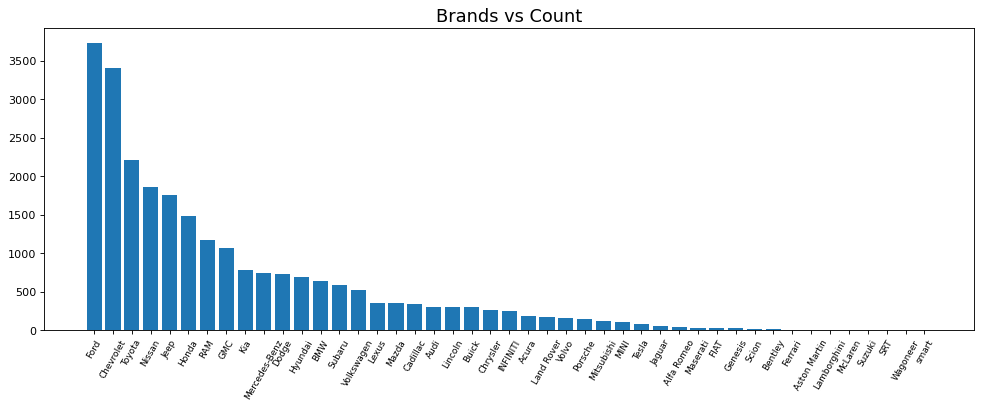

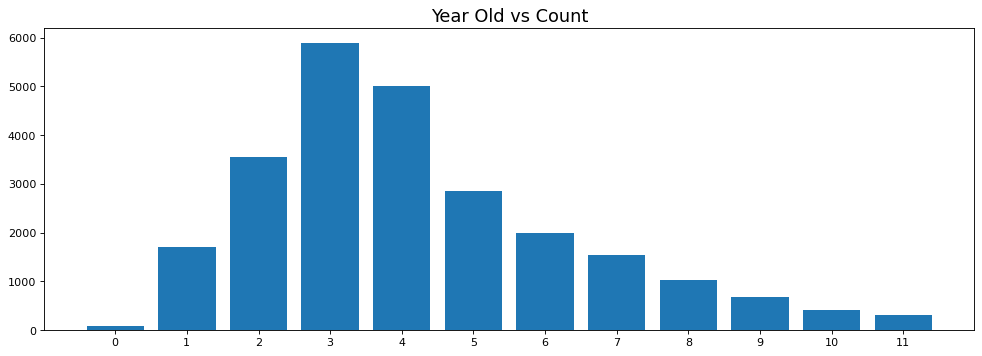

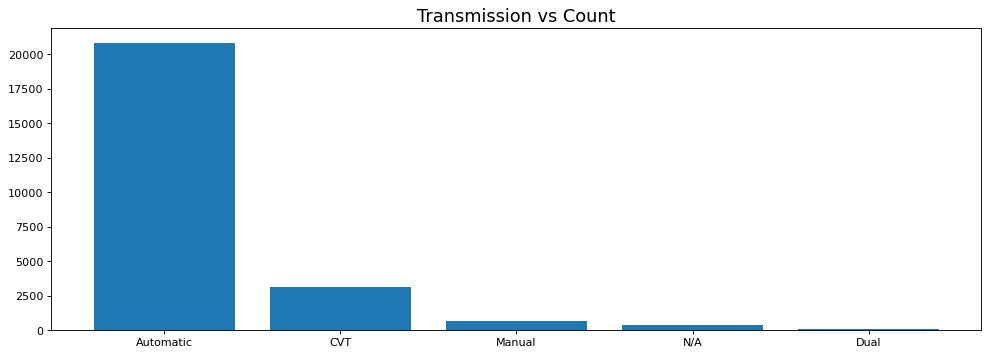

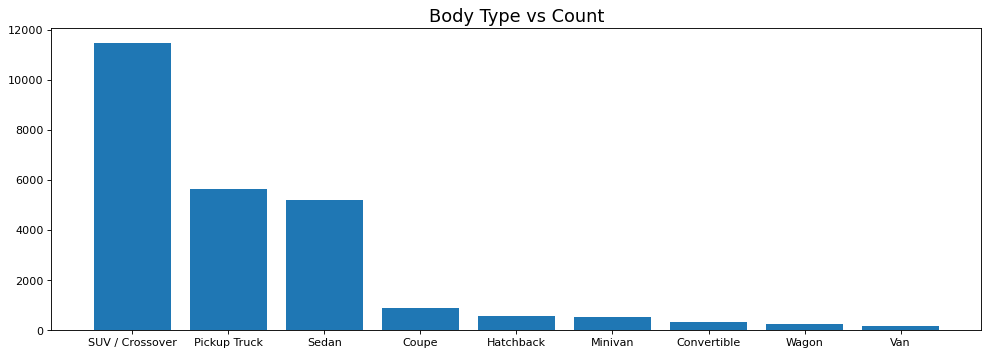

C:\Users\leeja\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


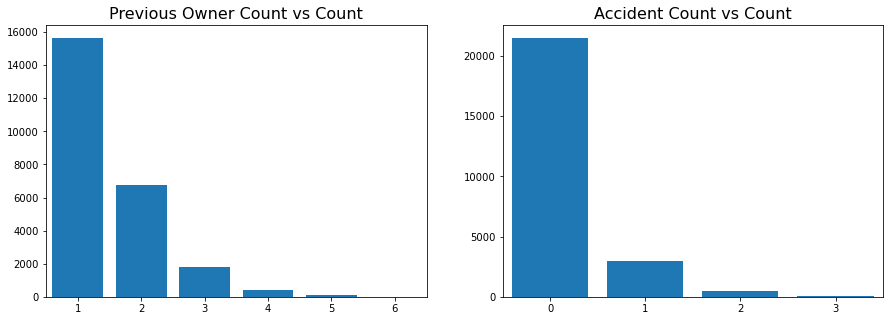

In [10]:
"""
EDA
"""

brand_count = df.groupby('Brand').size().sort_values(ascending=False)

plt.figure(figsize=(15, 5), dpi=80)
plt.bar(brand_count.index, brand_count)
plt.xticks(fontsize=8, rotation = 60) 
plt.title("Brands vs Count", fontsize=16)
plt.show()

year_count = df.groupby('YearOld').size()

plt.figure(figsize=(15, 5), dpi=80)
plt.bar(year_count.index, year_count)
plt.xticks(year_count.index, fontsize=10)
plt.title("Year Old vs Count", fontsize=16)
plt.show()

trans_count = df.groupby('Transmission').size().sort_values(ascending=False)

plt.figure(figsize=(15, 5), dpi=80)
plt.bar(trans_count.index, trans_count)
plt.xticks(trans_count.index, fontsize=10)
plt.title("Transmission vs Count", fontsize=16)
plt.show()

type_count = df.groupby('bodyTypeName').size().sort_values(ascending=False)

plt.figure(figsize=(15, 5), dpi=80)
plt.bar(type_count.index, type_count)
plt.xticks(type_count.index, fontsize=10)
plt.title("Body Type vs Count", fontsize=16)
plt.show()

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(15,5))

owner_count = df.groupby('OwnerCount').size()

ax[0].bar(owner_count.index, owner_count)
ax[0].set_xticks(owner_count.index, fontsize=10)
ax[0].set_title("Previous Owner Count vs Count", fontsize=16)
ax[0].set_xlim(0.5,6.5)

acc_count = df.groupby('AccidentCount').size()

ax[1].bar(acc_count.index, acc_count)
ax[1].set_xticks(acc_count.index, fontsize=10)
ax[1].set_title("Accident Count vs Count", fontsize=16)
ax[1].set_xlim([-0.5,3.5])

fig.show()

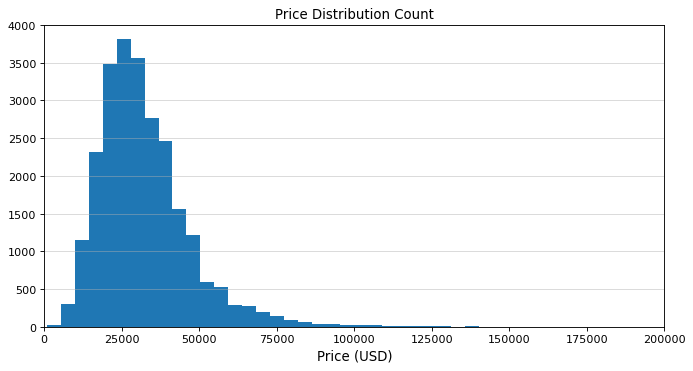

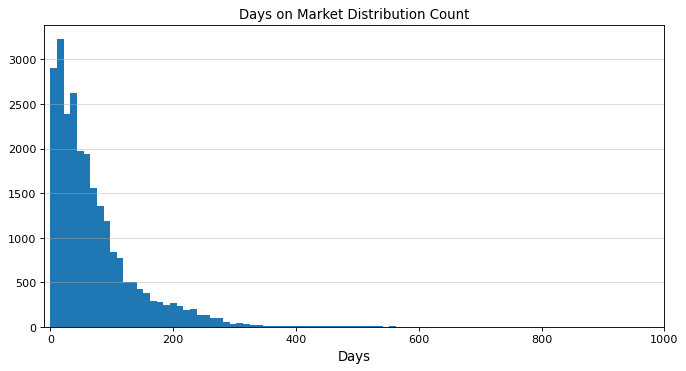

Text(0.5, 1.0, 'Correlation Matrix')

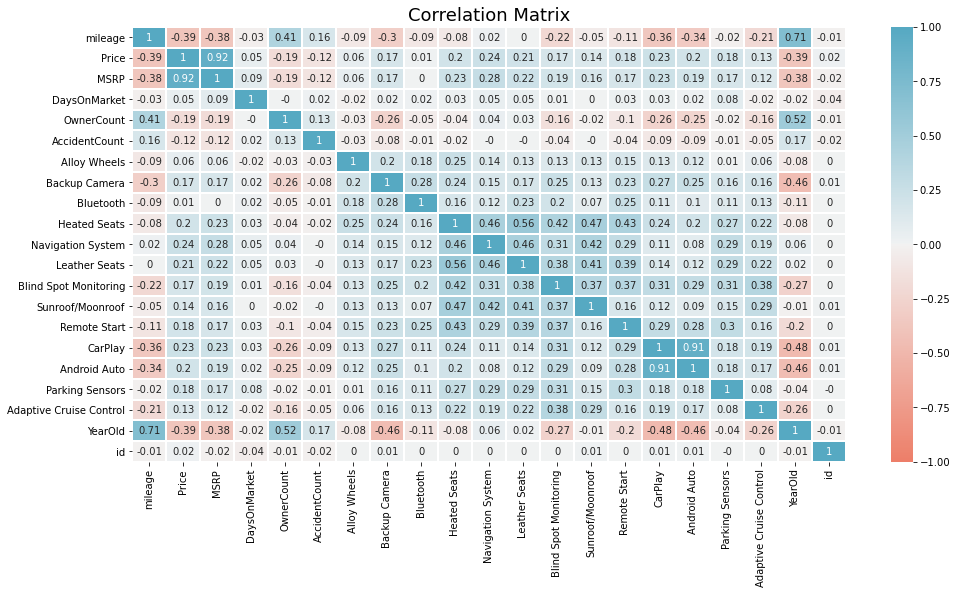

In [11]:
"""
Price Distribution
"""
plt.figure(figsize=(10, 5), dpi=80)
plt.xlim(0,200000)
plt.hist(df.Price, bins=200)
plt.grid('major', axis='y', alpha=0.5)
plt.title("Price Distribution Count")
plt.xlabel("Price (USD)", fontsize=12)

plt.show()

"""
Days on Market Distribution
"""
plt.figure(figsize=(10, 5), dpi=80)
plt.xlim(-10,1000)
plt.hist(df.DaysOnMarket, bins=200)
plt.grid('major', axis='y', alpha=0.5)
plt.title("Days on Market Distribution Count")
plt.xlabel("Days", fontsize=12)

plt.show()

"""
Correlation Matrix
"""

corr = df.corr().round(2)
cmap = sns.diverging_palette(20, 220, as_cmap=True, l=65)

plt.figure(figsize=(16, 8))

heatmap = sns.heatmap(corr, linewidth=0.1, vmin=-1, vmax=1, cmap=cmap, annot=True)
heatmap.set_title("Correlation Matrix", fontdict={'fontsize':18})

Price displays large correlation with respect to MSRP just as expected. Besides, the make year and mileages of the car also affect the price ranges. Surprisingly, how long the car was on the market has no correlation with the price; the most probable reason is that the latest demand for automobiles has surged incredibly, and not many cars remain unsold in the market for long time.  

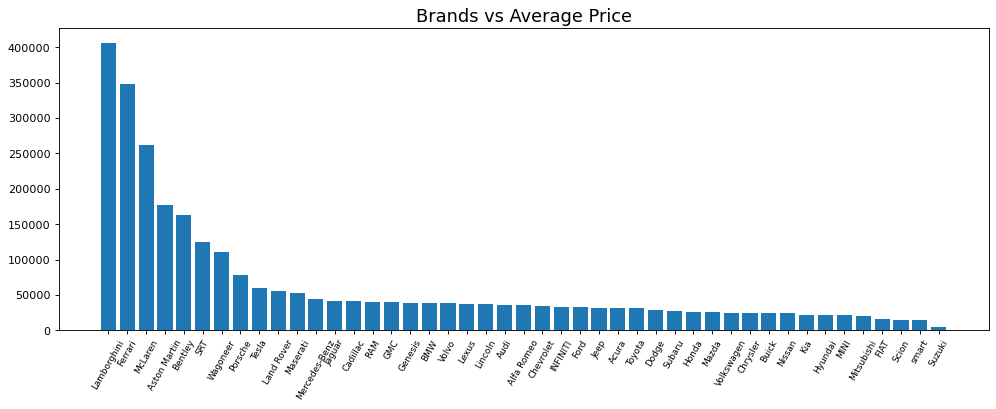

<Figure size 1200x800 with 0 Axes>

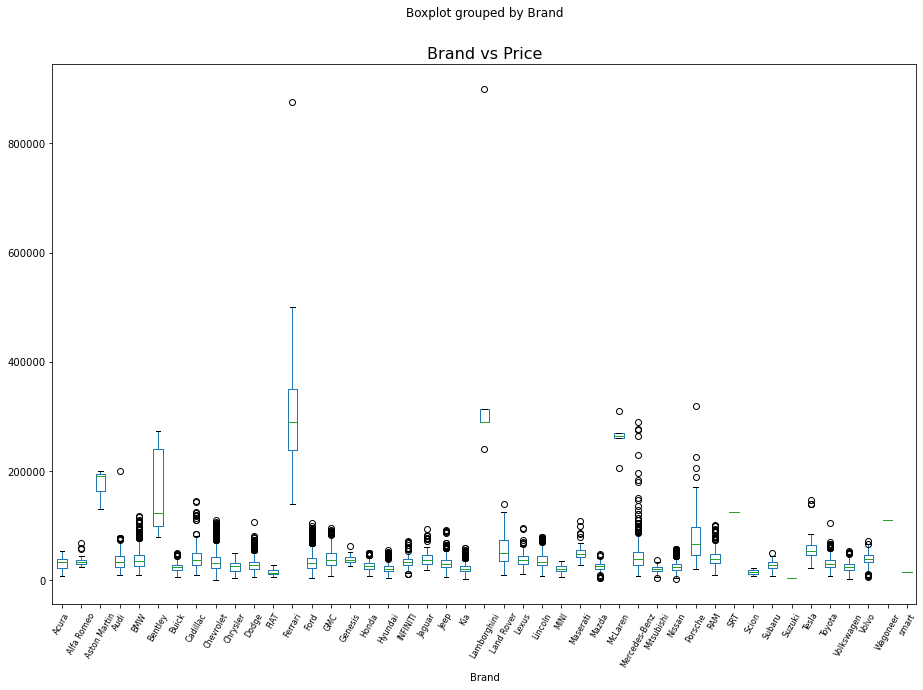

<Figure size 1200x800 with 0 Axes>

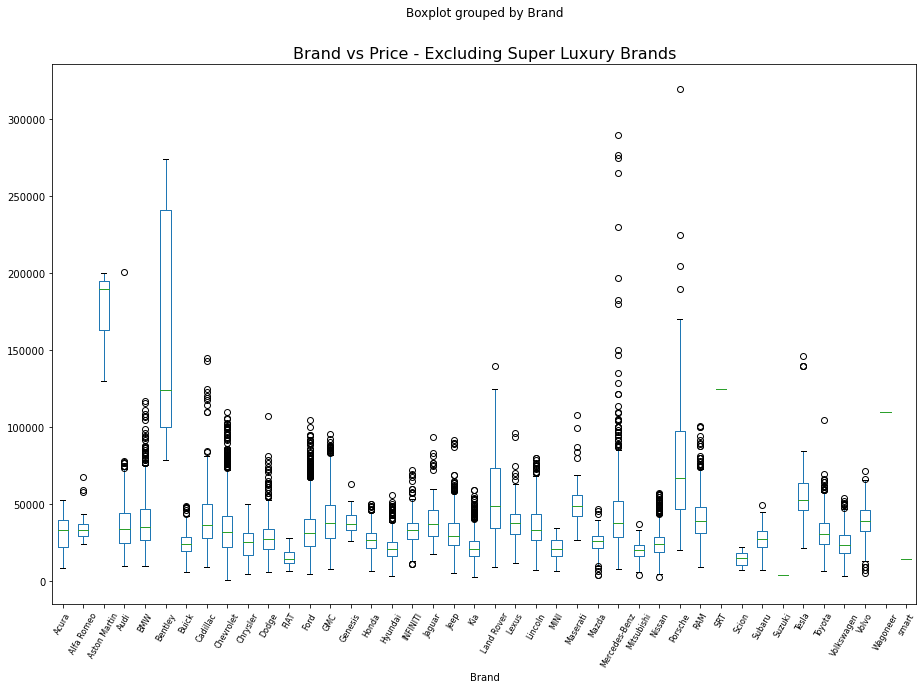

<Figure size 1200x800 with 0 Axes>

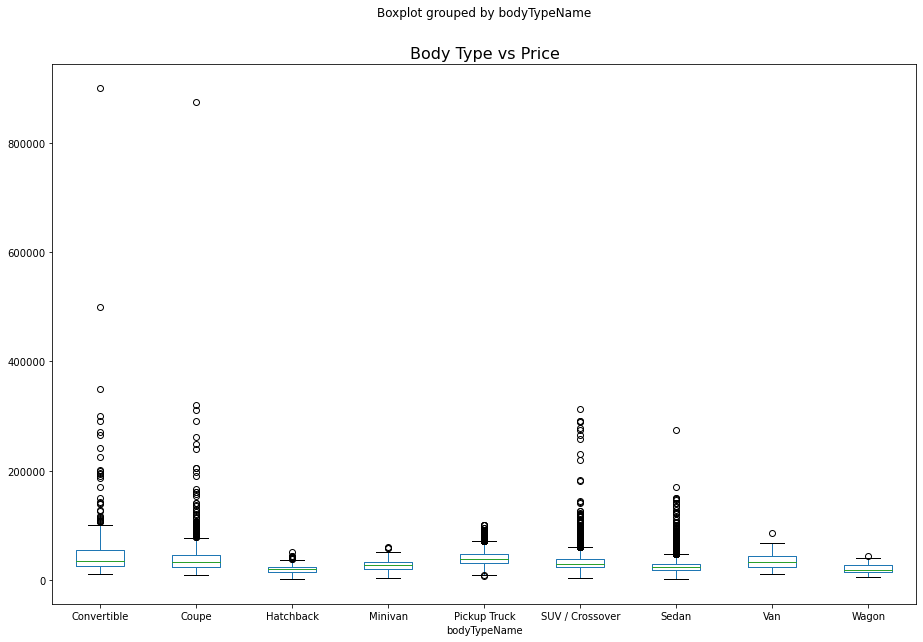

In [12]:
"""
Target(Price) Based Distribution - Categorical Columns
"""
brand_mean_price = df.groupby(['Brand'])['Price'].mean().sort_values(ascending=False)
plt.figure(figsize=(15, 5), dpi=80)
plt.bar(brand_mean_price.index, brand_mean_price)
plt.xticks(fontsize=8, rotation = 60) 
plt.title("Brands vs Average Price", fontsize=16)
plt.show()

plt.figure(figsize=(15, 10), dpi=80)
boxplot = df.boxplot(column='Price', by='Brand', figsize=(15, 10), grid=False)
boxplot.set_title("Brand vs Price", fontsize=16)
plt.xticks(fontsize=8, rotation=60)
plt.show()

plt.figure(figsize=(15, 10), dpi=80)
lux_brands = ['Rolls-Royce','Lamborghini','McLaren','Ferrari']

boxplot = df[~df['Brand'].isin(lux_brands)].boxplot(column='Price', by='Brand', figsize=(15, 10), grid=False)
boxplot.set_title("Brand vs Price - Excluding Super Luxury Brands", fontsize=16)
plt.xticks(fontsize=8, rotation=60)
plt.show()

#type_mean_price = df.groupby(['bodyTypeName'])['Price'].mean().sort_values(ascending=False)
plt.figure(figsize=(15, 10), dpi=80)
boxplot = df.boxplot(column='Price', by='bodyTypeName', figsize=(15, 10), grid=False)
boxplot.set_title("Body Type vs Price", fontsize=16)
plt.show()

In [13]:
"""
Feature Engineering
"""

# Train test split - 10% of whole dataset into test data
X = df.drop('Price', axis=1)
y = df.Price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

"""
Filling in Missing MSRP
"""

# There about 70% of missing MSRP entries. Using the msrp_dict we created earlier, fill NaN MSRP 
X_train['MSRP'] = X_train.apply(lambda x: msrp_avg[x['ModelID']] 
                 if x['ModelID'] in msrp_avg.keys() and pd.isnull(x['MSRP']) 
                 else x['MSRP'], axis=1)

X_test['MSRP'] = X_test.apply(lambda x: msrp_avg[x['ModelID']] 
                 if x['ModelID'] in msrp_avg.keys() and pd.isnull(x['MSRP']) 
                 else x['MSRP'], axis=1)

# It looks like some rows are still missing MSRP - replace with average of other rows with same ModelID
model_mean_price = X_train.groupby('ModelID')['MSRP'].mean().to_dict()

X_train['MSRP'] = X_train.apply(lambda x: model_mean_price[x['ModelID']] 
                 if x['ModelID'] in model_mean_price.keys() and pd.isnull(x['MSRP']) 
                 else x['MSRP'], axis=1)

X_test['MSRP'] = X_test.apply(lambda x: model_mean_price[x['ModelID']] 
                 if x['ModelID'] in model_mean_price.keys() and pd.isnull(x['MSRP']) 
                 else x['MSRP'], axis=1)

print("MSRP Missing Ratio for train X", (X_train['MSRP'].isna().sum() / len(X_train)).round(4))
print("MSRP Missing Ratio for test X", (X_test['MSRP'].isna().sum() / len(X_test)).round(4))

# Still few missing MSRP, let's put in the brand's mean price 
brand_mean_price = X_train.groupby('Brand')['MSRP'].mean().to_dict()

X_train['MSRP'] = X_train.apply(lambda x: brand_mean_price[x['Brand']] 
                 if x['Brand'] in brand_mean_price.keys() and pd.isnull(x['MSRP']) 
                 else x['MSRP'], axis=1)

X_test['MSRP'] = X_test.apply(lambda x: brand_mean_price[x['Brand']] 
                 if x['Brand'] in brand_mean_price.keys() and pd.isnull(x['MSRP']) 
                 else x['MSRP'], axis=1)


# Fill with average
X_train['MSRP'].fillna(X_train['MSRP'].mean(), inplace=True)
X_test['MSRP'].fillna(X_train['MSRP'].mean(), inplace=True) 

MSRP Missing Ratio for train X 0.0096
MSRP Missing Ratio for test X 0.0076


In [14]:
"""
Fill in missing entries for BodyType, FuelType, Owner Count & Accident Count
"""

# For BodyType and FuelType, inpute with most common body type with respect to each model 
for col in ['bodyTypeName','FuelType']:
    res = X_train.groupby(['ModelID',col]).size()
    res = res.reset_index()
    res = res.iloc[res.groupby(['ModelID'])[0].idxmax().values]
    conv_dict = dict(zip(res['ModelID'], res[col]))    
    for x in [X_train, X_test]:
        x[col] = x.apply(lambda row: conv_dict[row['ModelID']] 
                           if row['ModelID'] in conv_dict.keys() and pd.isnull(row[col])
                           else row[col], axis=1)

# For OwnerCount and AccidentCount, impute with the average count with respct to YearOld 
for col in ['OwnerCount','AccidentCount']:
    year_owner_cnt = X_train.groupby('YearOld')[col].mean().to_dict()
    for x in [X_train, X_test]:
        x[col] = x.apply(lambda row: year_owner_cnt[row['YearOld']] 
                           if pd.isnull(row[col]) else row[col], axis=1)
    

# Still very few missing entries 
print(X_train.isna().sum(), X_test.isna().sum())

Brand                      0
ModelName                  0
ModelID                    0
Color                      0
Transmission               0
mileage                    0
bodyTypeName               2
FuelType                   5
SellerState                0
MSRP                       0
DaysOnMarket               0
OwnerCount                 0
AccidentCount              0
Alloy Wheels               0
Backup Camera              0
Bluetooth                  0
Heated Seats               0
Navigation System          0
Leather Seats              0
Blind Spot Monitoring      0
Sunroof/Moonroof           0
Remote Start               0
CarPlay                    0
Android Auto               0
Parking Sensors            0
Adaptive Cruise Control    0
YearOld                    0
id                         0
dtype: int64 Brand                      0
ModelName                  0
ModelID                    0
Color                      0
Transmission               0
mileage                    0
b

In [15]:
"""
Categorical Columns Encoding
* Drop id and ModelName
* Target Encode Brand, ModelID, Color, bodyTypeName, sellerState
* One Hot Encode Transmission and FuelType
"""

# Drop unnecessary columns
X_train.drop(['id','ModelName'], axis=1, inplace=True)
X_test.drop(['id','ModelName'], axis=1, inplace=True)

# Save Index for later analysis
X_test_brand = X_test['Brand'].copy()
X_test_type = X_test['bodyTypeName'].copy()

# Target Encoding
target_enc_cols = ['Brand', 'ModelID', 'Color', 'bodyTypeName', 'SellerState']
enc = ce.target_encoder.TargetEncoder(return_df=True, handle_unknown='value')
X_train[target_enc_cols] = enc.fit_transform(X_train[target_enc_cols], y_train)
X_test[target_enc_cols] = enc.transform(X_test[target_enc_cols])

# One Hot Encoding
one_hot_cols = ['Transmission','FuelType']
enc = OneHotEncoder(handle_unknown='ignore')
encoded = enc.fit_transform(X_train[one_hot_cols]).toarray()
X_train[enc.get_feature_names_out()] = encoded
X_train.drop(one_hot_cols, axis=1, inplace=True)

encoded = enc.transform(X_test[one_hot_cols]).toarray()
X_test[enc.get_feature_names_out()] = encoded
X_test.drop(one_hot_cols, axis=1, inplace=True)


C:\Users\leeja\anaconda3\envs\py37\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [16]:
display(X_train, X_test)

,Brand,ModelID,Color,mileage,bodyTypeName,SellerState,MSRP,DaysOnMarket,OwnerCount,AccidentCount,...,Transmission_N/A,FuelType_Biodiesel,FuelType_Compressed Natural Gas,FuelType_Diesel,FuelType_Electric,FuelType_Flex Fuel Vehicle,FuelType_Fuel Cell,FuelType_Gasoline,FuelType_Hybrid,FuelType_nan
1527,55223.480263,77494.230769,31817.063394,23123,32046.520288,33669.860825,83082.250000,26,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7458,24562.455704,21148.736364,33577.058669,40269,25396.711974,30119.302852,31241.333333,48,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15608,26556.139865,24973.391144,33577.058669,77863,25396.711974,32099.978558,30089.285714,15,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16784,31107.640060,25514.558824,30323.412981,50117,25396.711974,36936.731903,31762.000000,18,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20496,44568.600176,33318.734694,34115.776802,27880,25396.711974,36936.731903,49570.000000,27,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,33661.267638,38869.706653,33577.058669,68727,40047.674803,31172.416342,50629.220779,3,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5390,31107.640060,41213.432836,33577.058669,29656,40047.674803,34697.672889,54304.625000,35,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
860,33661.267638,49932.700787,34115.776802,17301,40047.674803,30538.506098,63385.000000,26,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15795,24562.455704,17963.994413,30323.412981,5685,25396.711974,34697.672889,23762.000000,46,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


,Brand,ModelID,Color,mileage,bodyTypeName,SellerState,MSRP,DaysOnMarket,OwnerCount,AccidentCount,...,Transmission_N/A,FuelType_Biodiesel,FuelType_Compressed Natural Gas,FuelType_Diesel,FuelType_Electric,FuelType_Flex Fuel Vehicle,FuelType_Fuel Cell,FuelType_Gasoline,FuelType_Hybrid,FuelType_nan
7217,33661.267638,29666.360656,31544.558583,34786,32046.520288,30119.302852,33995.000000,81,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8909,24778.347280,24227.816667,33577.058669,114848,25396.711974,30538.506098,42121.666667,69,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24535,28852.287462,35267.962963,30323.412981,41510,42418.888752,36936.731903,40330.416667,60,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16098,26556.139865,32273.573964,34430.249468,59433,32046.520288,36936.731903,44420.000000,88,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6215,38618.757366,27966.288462,34115.776802,24921,25396.711974,36936.731903,35482.000000,83,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16683,31107.640060,25514.558824,34115.776802,7906,25396.711974,33178.264553,31762.000000,242,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11150,24562.455704,22416.953488,30485.084211,19224,32046.520288,32099.978558,32934.000000,1,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16206,39585.661554,48906.949580,34115.776802,66636,32046.520288,36936.731903,79787.500000,48,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12560,31252.527549,37771.082569,34115.776802,33303,32046.520288,33178.264553,43907.500000,154,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Modeling
* Linear Regression
* Polynomial Regression
* Random Forest Regressor
* XGB Regressor

In [17]:
model = LinearRegression(fit_intercept=True, n_jobs=4)
reg = model.fit(X_train, y_train)
pred = model.predict(X_test)

#R^2 Score
print("Linear Regression R^2 Score for test set: ", reg.score(X_test, y_test))
print("Linear Regression MSE: ", mean_squared_error(pred, y_test))
print("Linear Regression MAE: ", mean_absolute_error(pred, y_test))

Linear Regression R^2 Score for test set:  0.7970968632917241
Linear Regression MSE:  50634193.80894302
Linear Regression MAE:  4645.562405644865


In [18]:
# Polynomial Regression - degree 2
poly = PolynomialFeatures(degree=2)
X_train_ = poly.fit_transform(X_train)
X_test_ = poly.fit_transform(X_test)

model = LinearRegression(fit_intercept=True, n_jobs=4)
reg = model.fit(X_train_, y_train)
pred = model.predict(X_test_)

print("Polynomial Regression R^2 Score for test set: ", reg.score(X_test_, y_test))
print("Polynomial Regression MSE: ", mean_squared_error(pred, y_test))
print("Polynomial Regression MAE: ", mean_absolute_error(pred, y_test))

Polynomial Regression R^2 Score for test set:  0.8688375128536442
Polynomial Regression MSE:  32731415.109565906
Polynomial Regression MAE:  3707.6757406052684


In [19]:
# Random Forest Regressor - With Randomized Parameter Searching
rf = RandomForestRegressor(random_state=42)
params = {'n_estimators':[50,100,150], 'max_depth':[None,3,4], 'min_samples_split':[2,3,4]}
model = RandomizedSearchCV(rf, params, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=100)
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 4],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [50, 100, 150]},
                   scoring='neg_mean_squared_error', verbose=100)

In [20]:
print(model.best_params_)
pred = model.predict(X_test)
print("MSE: ", mean_squared_error(pred, y_test))
print("MAE: ", mean_absolute_error(pred, y_test))

{'n_estimators': 50, 'min_samples_split': 4, 'max_depth': None}
MSE:  19646762.412343446
MAE:  2839.715913100012


In [21]:
# With the best parameter
rf = RandomForestRegressor(n_estimators=50, min_samples_split=4, max_depth=None, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print("Test MSE: ", mean_squared_error(pred, y_test))
print("Test MAE: ", mean_absolute_error(pred, y_test))

pred = rf.predict(X_train)
print("Train MSE: ", mean_squared_error(pred, y_train))
print("Train MAE: ", mean_absolute_error(pred, y_train))

# Show feature importances 
feature_dict = dict(zip(rf.feature_names_in_, rf.feature_importances_.round(4)))
display(sorted(feature_dict.items(), key=lambda x:x[1], reverse=True))

Test MSE:  19646762.412343446
Test MAE:  2839.715913100012
Train MSE:  9697690.713970091
Train MAE:  1229.3376233433778


[('ModelID', 0.4312),
 ('Brand', 0.2103),
 ('YearOld', 0.1299),
 ('mileage', 0.1184),
 ('MSRP', 0.0475),
 ('DaysOnMarket', 0.0087),
 ('FuelType_nan', 0.007),
 ('SellerState', 0.0057),
 ('bodyTypeName', 0.0053),
 ('Color', 0.0041),
 ('Heated Seats', 0.0034),
 ('Navigation System', 0.0032),
 ('Leather Seats', 0.0026),
 ('FuelType_Biodiesel', 0.0024),
 ('FuelType_Gasoline', 0.0023),
 ('OwnerCount', 0.0018),
 ('Remote Start', 0.0018),
 ('Parking Sensors', 0.0017),
 ('Adaptive Cruise Control', 0.0015),
 ('Alloy Wheels', 0.0014),
 ('Blind Spot Monitoring', 0.0014),
 ('Sunroof/Moonroof', 0.0014),
 ('Backup Camera', 0.0013),
 ('AccidentCount', 0.0008),
 ('CarPlay', 0.0008),
 ('Android Auto', 0.0008),
 ('Bluetooth', 0.0007),
 ('FuelType_Diesel', 0.0006),
 ('FuelType_Flex Fuel Vehicle', 0.0006),
 ('Transmission_Automatic', 0.0005),
 ('Transmission_N/A', 0.0004),
 ('Transmission_Manual', 0.0003),
 ('FuelType_Electric', 0.0002),
 ('Transmission_CVT', 0.0001),
 ('Transmission_Dual', 0.0),
 ('FuelTy

In [22]:
# XGB Regressor - Randomized Search
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
params = {'n_estimators':[700,800,900], 'max_depth':[5,6], 'learning_rate':[0.1]}
model = RandomizedSearchCV(xgb, params, n_iter=5, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
model.fit(X_train, y_train)

print(model.best_params_)
pred = model.predict(X_test)
print("MSE: ", mean_squared_error(pred, y_test))
print("MAE: ", mean_absolute_error(pred, y_test))

{'n_estimators': 800, 'max_depth': 5, 'learning_rate': 0.1}
MSE:  18771868.738380343
MAE:  2731.370283595928


In [24]:
# With the best parameters searched
xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', n_estimators=800
                   , max_depth=5, learning_rate=0.1)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
print("XGB MSE: ", mean_squared_error(pred, y_test))
print("XGB MAE: ", mean_absolute_error(pred, y_test))

XGB MSE:  18771868.738380343
XGB MAE:  2731.370283595928


In [145]:
## Neural Network Model with PyTorch

# Begin with scaling 
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))
X_train_scaled.columns = X_train.columns
X_test_scaled.columns = X_test.columns

display(X_train_scaled, X_test_scaled)

,Brand,ModelID,Color,mileage,bodyTypeName,SellerState,MSRP,DaysOnMarket,OwnerCount,AccidentCount,...,Transmission_N/A,FuelType_Biodiesel,FuelType_Compressed Natural Gas,FuelType_Diesel,FuelType_Electric,FuelType_Flex Fuel Vehicle,FuelType_Fuel Cell,FuelType_Gasoline,FuelType_Hybrid,FuelType_nan
0,0.102823,0.234820,0.325759,0.084054,0.347102,0.671432,0.197204,0.012015,0.125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.022994,0.036060,0.402523,0.146931,0.161933,0.500293,0.074155,0.022181,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.028184,0.049551,0.402523,0.284793,0.161933,0.595763,0.071420,0.006932,0.000,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.040035,0.051460,0.260613,0.183045,0.161933,0.828897,0.075390,0.008318,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.075082,0.078990,0.426019,0.101499,0.161933,0.828897,0.117660,0.012477,0.125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22594,0.046683,0.098571,0.402523,0.251290,0.569899,0.551054,0.120174,0.001386,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22595,0.040035,0.106838,0.402523,0.108012,0.569899,0.720973,0.128898,0.016174,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22596,0.046683,0.137596,0.426019,0.062704,0.569899,0.520499,0.150451,0.012015,0.000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22597,0.022994,0.024826,0.260613,0.020107,0.161933,0.720973,0.056402,0.021257,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


,Brand,ModelID,Color,mileage,bodyTypeName,SellerState,MSRP,DaysOnMarket,OwnerCount,AccidentCount,...,Transmission_N/A,FuelType_Biodiesel,FuelType_Compressed Natural Gas,FuelType_Diesel,FuelType_Electric,FuelType_Flex Fuel Vehicle,FuelType_Fuel Cell,FuelType_Gasoline,FuelType_Hybrid,FuelType_nan
0,0.046683,0.066106,0.313874,0.126824,0.347102,0.500293,0.080691,0.037431,0.125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.023556,0.046921,0.402523,0.420421,0.161933,0.520499,0.099980,0.031885,0.375,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.034163,0.085866,0.260613,0.151482,0.635927,0.828897,0.095728,0.027726,0.125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.028184,0.075303,0.439735,0.217208,0.347102,0.828897,0.105436,0.040665,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.059591,0.060109,0.426019,0.090648,0.161933,0.828897,0.084220,0.038355,0.250,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2506,0.040035,0.051460,0.426019,0.028252,0.161933,0.647737,0.075390,0.111830,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2507,0.022994,0.040534,0.267665,0.069756,0.347102,0.595763,0.078172,0.000462,0.000,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2508,0.062108,0.133977,0.426019,0.243622,0.347102,0.828897,0.189384,0.022181,0.125,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2509,0.040412,0.094696,0.426019,0.121386,0.347102,0.647737,0.104219,0.071165,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

X_train_tensor = torch.tensor(X_train_scaled.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32))

train_tensor = TensorDataset(X_train_tensor, y_train_tensor) 

# Train valid split - 10% Valid set
train_len = int(len(X_tensor) * 0.9)
train_ds, valid_ds = random_split(train_tensor, [train_len, len(X_tensor) - train_len])

# DataLoader
batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size)

In [143]:
input_dim = X_train_scaled.shape[1]
output_dim = 1

class LinRegModel(nn.Module):
    def __init__(self):
        super(LinRegModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 16)
        self.linear4 = nn.Linear(16, output_dim)

    def forward(self, x):
        out = F.relu(self.linear1(x))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = self.linear4(out)
        
        return out 
    
    def train_step(self, batch):
        x_input, price = batch
        output = self(x_input)
        loss = F.mse_loss(output, price.reshape(-1,1))
        
        return loss, output, price

In [144]:
model = LinRegModel()
lr = 0.005

optimizer = torch.optim.Adam(model.parameters(), lr)
epochs = 200

# Training & Validation
for i in range(epochs):
    counter = 0 
    for batch in train_loader:
        counter += 1
        loss, output, price = model.train_step(batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        """
        if counter % 50 == 0:
            print("Training Loss: ", loss)
            #print("Training MAPE: ", mean_absolute_percentage_error(output.detach().numpy(), price.detach().numpy()))
            print("Training MAE: ", mean_absolute_error(output.detach().numpy(), price.detach().numpy()))
        """
    # Validation
    val_loss = []
    val_mape = []
    val_mae = []
    
    for x_input, price in valid_loader:
        output = model(x_input)
        loss = F.mse_loss(output, price.reshape(-1,1))
        val_loss.append(loss.item())
        val_mape.append(mean_absolute_percentage_error(output.detach().numpy(), price.detach().numpy()))
        val_mae.append(mean_absolute_error(output.detach().numpy(), price.detach().numpy()))
    
    if i % 10 == 0:
        print("Epoch %d Val loss: " %i, sum(val_loss) / len(val_loss))
        #print("Val MAPE: ", sum(val_mape) / len(val_mape))  
        print("Epoch %d Val MAE: " %i, sum(val_mae) / len(val_mae))        

Epoch 0 Val loss:  991677447.1111112
Epoch 0 Val MAE:  27313.39431423611
Epoch 10 Val loss:  73934933.33333333
Epoch 10 Val MAE:  5314.968804253473
Epoch 20 Val loss:  33143237.111111112
Epoch 20 Val MAE:  3924.5324435763887
Epoch 30 Val loss:  34030123.55555555
Epoch 30 Val MAE:  3825.50537109375
Epoch 40 Val loss:  34230168.88888889
Epoch 40 Val MAE:  3792.0670572916665
Epoch 50 Val loss:  36712874.666666664
Epoch 50 Val MAE:  3937.4720865885415
Epoch 60 Val loss:  35588362.88888889
Epoch 60 Val MAE:  3798.1376953125
Epoch 70 Val loss:  34193819.777777776
Epoch 70 Val MAE:  3770.789849175347
Epoch 80 Val loss:  36113124.222222224
Epoch 80 Val MAE:  4021.273627387153
Epoch 90 Val loss:  35908555.11111111
Epoch 90 Val MAE:  3910.0831163194443
Epoch 100 Val loss:  34503179.333333336
Epoch 100 Val MAE:  3812.61962890625
Epoch 110 Val loss:  32833171.111111112
Epoch 110 Val MAE:  3747.1993001302085
Epoch 120 Val loss:  31803663.555555556
Epoch 120 Val MAE:  3695.1349012586807
Epoch 130 Va

In [148]:
# Now measure performance on the test set
X_test_tensor = torch.tensor(X_test_scaled.values.astype(np.float32))
pred = model(X_test_tensor).detach().numpy()
print("MSE: ", mean_squared_error(pred, y_test))
print("MAE: ", mean_absolute_error(pred, y_test))

MSE:  33476837.693049263
MAE:  3690.874766239484


XGB Regressor shows the best performances in both MSE and MAE. 

## Model Prediction Analysis - XGB

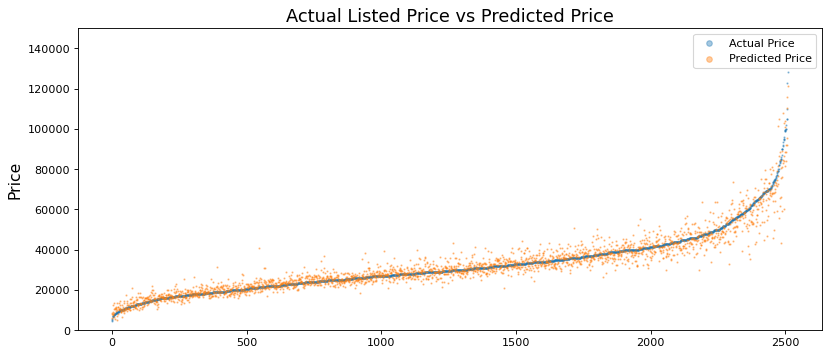

-------------------- Mean Absolute Percentage Error on Prediction by Brands -------------------- 

Ford : 9.71%
Chevrolet : 8.14%
Toyota : 7.30%
Nissan : 7.92%


-------------------- Mean Absolute Percentage Error on Prediction by Body Types -------------------- 

Sedan : 8.93%
SUV / Crossover : 7.75%
Minivan : 7.32%
Hatchback : 8.34%
Wagon : 10.44%
Pickup Truck : 8.77%
Coupe : 14.04%
Convertible : 15.90%
Van : 9.81%


In [26]:
res = pd.DataFrame(y_test)

# Add predicted price by the XGB regressor
res['Predicted Price'] = pred

# Concatenate original brand name
res = pd.concat([res, X_test_brand, X_test_type], axis=1)

# Reorder in the ascending price
res = res.sort_values('Price')
res.reset_index(inplace=True)

# Scatter Plot - Actual vs Predicted Price
plt.figure(figsize=(12, 5), dpi=80)
plt.scatter(res.index, res['Price'], alpha=0.4, s=1, label="Actual Price")
plt.scatter(res.index, res['Predicted Price'], alpha=0.4, s=1, label='Predicted Price')
plt.legend(markerscale=5)
plt.title('Actual Listed Price vs Predicted Price', fontsize=16)
plt.ylabel("Price", fontsize=14)
plt.ylim(0,150000)
plt.show()

major_brands = ['Ford','Chevrolet','Toyota','Nissan']
body_types = list(res['bodyTypeName'].unique())

if np.nan in body_types:
    body_types.remove(np.nan)

# mean_absolute_percentage_error(MAPE) - by brands
print("-"*20, "Mean Absolute Percentage Error on Prediction by Brands", "-"*20, "\n")
for b in major_brands:
    err = mean_absolute_percentage_error(res[res['Brand'] == b]['Price'], res[res['Brand'] == b]['Predicted Price'])
    print(b, ": {:.2%}".format(err))
    
print('\n')    
    
# mean_absolute_percentage_error - by body types
print("-"*20, "Mean Absolute Percentage Error on Prediction by Body Types", "-"*20, "\n")
for b in body_types:
    err = mean_absolute_percentage_error(res[res['bodyTypeName'] == b]['Price'], res[res['bodyTypeName'] == b]['Predicted Price'])
    print(b, ": {:.2%}".format(err))

Text(-0.02, 0.5, 'Price')

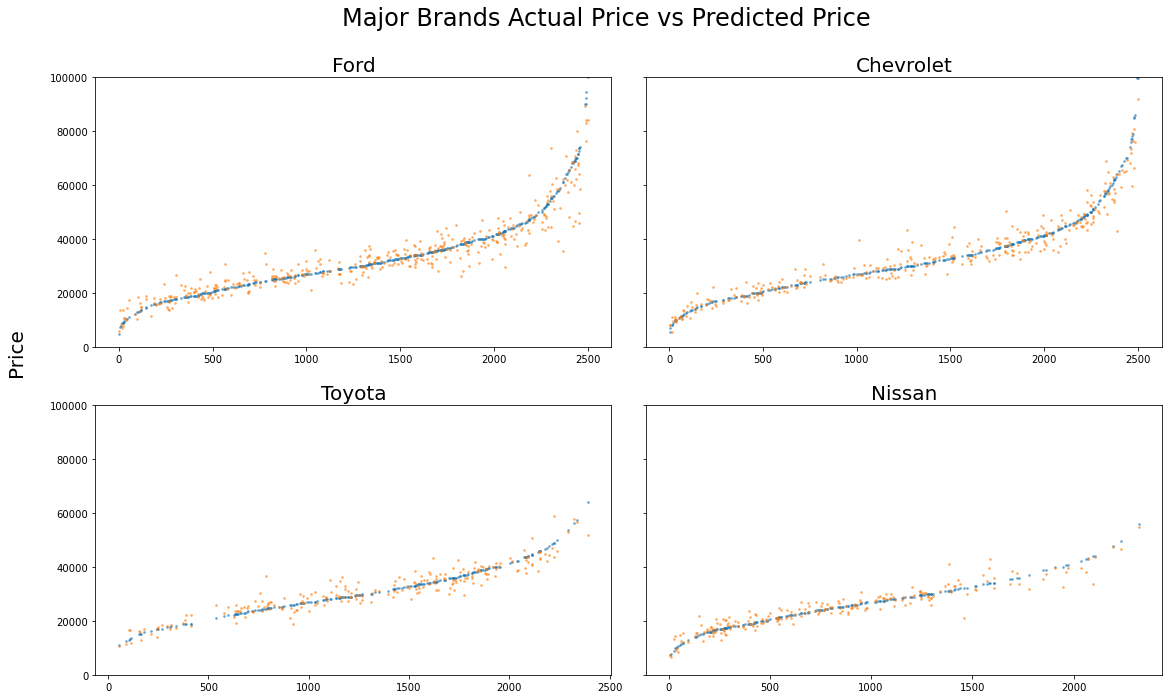

In [27]:
# Scatter Plot for Major Brands
fig, ax = plt.subplots(2,2, figsize=(16,10), sharey=True)
res_major_brands = res[res['Brand'].isin(major_brands)]

for i,b in enumerate(major_brands):
    res_brand = res_major_brands[res_major_brands['Brand'] == b]
    ax[int(i/2)][i%2].scatter(res_brand.index, res_brand['Price'], alpha=0.5, s=3, label="Actual Price")
    ax[int(i/2)][i%2].scatter(res_brand.index, res_brand['Predicted Price'], alpha=0.5, s=3, label="Predicted Price")
    ax[int(i/2)][i%2].set_title(b, fontsize=20)
    ax[int(i/2)][i%2].set_ylim(0,100000)

fig.suptitle("Major Brands Actual Price vs Predicted Price", fontsize=24)
fig.tight_layout(pad=2.0)
fig.supylabel('Price', fontsize=20, position=(-0.02,0.5))

Results of price prediction show that for four major brands (Ford, Chevy, Toyota and Nissan), the mean absolute percentage error seems to be in the range between 7 to 10%. 

For body types, we can see that absolute errors for sedan/SUV automobiles are relatively lower than those of other types like convertible/coupe. It may be due to the fact that these types (convertible, coupe) are rarer in the auto markets. Moreover, these types are likely to have vast price ranges, since super luxury makers produce these types of vehicles.

## Takeaway

In average, our prediction is about 10% off from the listed price. The model still lacks precision in terms of application.
In order to improve the model, I believe that we need more accurate data on MSRP; even for the same models, the retail prices can vary widely by options and packages included. Since the MSRP imputation method I used here takes the average MSRP for each model, it does not provide accurate retail price that the original owners paid. 